In [8]:
from PIL import Image
from collections import Counter
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from colorspacious import cspace_converter
import numpy as np




def get_pixels_img(image_path):
    with Image.open(image_path) as img:
        # Resize the image for faster processing if needed
        img = img.resize((50, 50))
        # Get the dimensions of the image
        width, height = img.size
        # Extract pixels from the defined slice
        return list(img.crop((0, (height/5)*2, width, (height/5)*3)).getdata())

def get_pixels(image_paths):
    # Get average colors for all images
    return [get_pixels_img(image_path) for image_path in image_paths]

def rgb_to_lab(rgb):
    # Convert RGB to CIE Lab
    rgb_normalized = np.array(rgb) / 255.0
    lab = cspace_converter("sRGB1", "CIELab")(rgb_normalized)
    return lab

def delta_e_1976(color1, color2):
    lab1 = rgb_to_lab(color1)
    lab2 = rgb_to_lab(color2)

    # Calculate Delta E 1976
    delta_e = np.sqrt(np.sum((lab2 - lab1)**2))
    return delta_e

def relative_luminance(rgb):
    # Convert each color component to a fraction of 1
    r, g, b = [x / 255.0 for x in rgb]

    # Apply the sRGB transformation for linearization
    if r <= 0.03928:
        r = r / 12.92
    else:
        r = ((r + 0.055) / 1.055) ** 2.4

    if g <= 0.03928:
        g = g / 12.92
    else:
        g = ((g + 0.055) / 1.055) ** 2.4

    if b <= 0.03928:
        b = b / 12.92
    else:
        b = ((b + 0.055) / 1.055) ** 2.4

    # Calculate the relative luminance
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b

    return luminance


def contrast_ratio(p1, p2):
    l1 = relative_luminance(p1)
    l2 = relative_luminance(p2)
    if l1 > l2:
        return (l1 + 0.05) / (l2 + 0.05)
    else:
        return (l2 + 0.05) / (l1 + 0.05)
    
def contrast_list(color, pixels):
    return [delta_e_1976(color, pixel) for pixel in pixels]

def avg_contrast(color, pixels):
    contrasts = contrast_list(color, pixels)
    return sum(contrasts)/len(contrasts)

def avg_contrast_list(color, pixelss):
    contrasts = [avg_contrast(color, pixels) for pixels in pixelss]
    return sum(contrasts)/len(contrasts)

def print_result(cname, color, pixels):
    print(cname + " : ", avg_contrast_list(color, pixels))

def average_rgb(pixels):
    # Calculate the average RGB values
    num_pixels = len(pixels)
    if num_pixels == 0:
        return None

    # Sum the RGB values separately
    sum_r, sum_g, sum_b = 0, 0, 0
    for pixel in pixels:
        r,g,b = pixel
        sum_r += r
        sum_g += g
        sum_b += b

    # Calculate the average RGB values
    avg_r = sum_r / num_pixels
    avg_g = sum_g / num_pixels
    avg_b = sum_b / num_pixels

    return (avg_r, avg_g, avg_b)

# Replace this with the path to your JPEG images
image_folder = "mappics"

# Get a list of all JPEG files in the folder
image_paths = [
    os.path.join(image_folder, file)
    for file in os.listdir(image_folder)
    if file.lower().endswith((".jpg", ".jpeg"))
]

if not image_paths:
    print("No JPEG images found in the specified folder.")

pixels = get_pixels(image_paths)

#colors=[(255,255,255),(0,255,255),(255,0,255),(255,255,0),(0,0,255),(255,0,0),(0,255,0),(0,0,0)]
#color_names = ["White", "Cyan", "Pink", "Yellow", "Blue", "Red", "Lime", "Black"]
#for i in range(len(color_names)):
#    print_result(color_names[i], colors[i], pixels)

colors = []
step = 32
start = -1
for i in range(start, 256, step):
    for j in range(start, 256, step):
        for k in range(start, 256, step):
            if (i == -1): i = 0
            if (j == -1): j = 0
            if (k == -1): k = 0
            colors.append((i, j, k))


scores = []
progress_counter = 0
for color in colors:
    scores.append((color, avg_contrast_list(color, pixels)))
    progress_counter += 1
    if (progress_counter % 100) == 0:
        print("Processed colors:", progress_counter)

sorted_scores = sorted(scores, key=lambda x: x[1])
for i in range(1, 20):
    print(sorted_scores[-i])

    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract RGB values and scores for plotting
r_values = [color[0] for color, _ in scores]
g_values = [color[1] for color, _ in scores]
b_values = [color[2] for color, _ in scores]
scores_values = [score for _, score in scores]

# Plot the data
ax.scatter(r_values, g_values, b_values, c=scores_values, cmap='cool', s=50)

# Add labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Color Contrast Scores')

# Show the plot
plt.show()


from avg:  54.71969451065913
from all:  51.408058951419285


' colors=[(255,255,255),(0,255,255),(255,0,255),(255,255,0),(0,0,255),(255,0,0),(0,255,0),(0,0,0)]\ncolor_names = ["White", "Cyan", "Pink", "Yellow", "Blue", "Red", "Lime", "Black"]\nfor i in range(len(color_names)):\n    print_result(color_names[i], colors[i], pixels)\n\ncolors = []\nstep = 32\nstart = -1\nfor i in range(start, 256, step):\n    for j in range(start, 256, step):\n        for k in range(start, 256, step):\n            if (i == -1): i = 0\n            if (j == -1): j = 0\n            if (k == -1): k = 0\n            colors.append((i, j, k))\n\n\nscores = []\nprogress_counter = 0\nfor color in colors:\n    scores.append((color, avg_contrast_list(color, pixels)))\n    progress_counter += 1\n    if (progress_counter % 100) == 0:\n        print("Processed colors:", progress_counter)\n\nsorted_scores = sorted(scores, key=lambda x: x[1])\nfor i in range(1, 20):\n    print(sorted_scores[-i])\n\n    \nfig = plt.figure()\nax = fig.add_subplot(111, projection=\'3d\')\n\n# Extract 

In [6]:
# Plot the data using Plotly
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
scatter = go.Scatter3d(
    x=r_values,
    y=g_values,
    z=b_values,
    mode='markers',
    marker=dict(
        size=15,
        color=scores_values,
        colorscale="Plasma",
        opacity=1
    )
    
)
fig.add_trace(scatter)

# Set layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Red'),
        yaxis=dict(title='Green'),
        zaxis=dict(title='Blue')
    ),
    title='Color Contrast Scores',
    margin=dict(l=0, r=0, b=0, t=0)
)

# Save the figure as an interactive HTML file
fig.write_html('color_contrast_scores_interac.html')

70875
White 70875


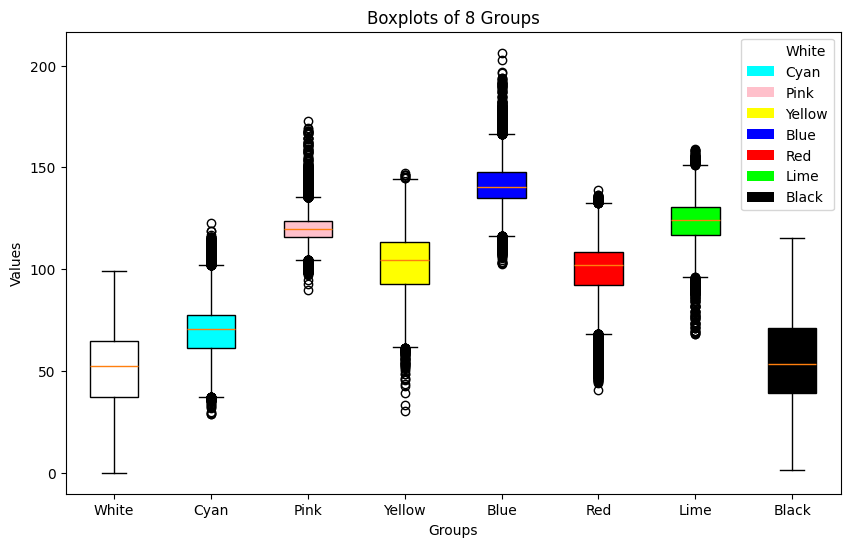

In [14]:
from PIL import Image
from collections import Counter
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from colorspacious import cspace_converter
import numpy as np




def get_pixels_img(image_path):
    with Image.open(image_path) as img:
        # Resize the image for faster processing if needed
        img = img.resize((75, 75))
        # Get the dimensions of the image
        width, height = img.size
        # Extract pixels from the defined slice
        return list(img.crop((0, (height/5)*1, width, (height/5)*4)).getdata())

def get_pixels(image_paths):
    pixels = []
    for image_path in image_paths:
        pixels.extend(get_pixels_img(image_path))
    return pixels

def rgb_to_lab(rgb):
    # Convert RGB to CIE Lab
    rgb_normalized = np.array(rgb) / 255.0
    lab = cspace_converter("sRGB1", "CIELab")(rgb_normalized)
    return lab

def delta_e_1976(color1, color2):
    lab1 = rgb_to_lab(color1)
    lab2 = rgb_to_lab(color2)

    # Calculate Delta E 1976
    delta_e = np.sqrt(np.sum((lab2 - lab1)**2))
    return delta_e

def colorDataList(colors, pixels):
    res = []
    for color in colors:
        name, color = color
        res_list = [delta_e_1976(color, pixel) for pixel in pixels]
        res.append((name, res_list))
    return res

# Replace this with the path to your JPEG images
image_folder = "mappics"

# Get a list of all JPEG files in the folder
image_paths = [
    os.path.join(image_folder, file)
    for file in os.listdir(image_folder)
    if file.lower().endswith((".jpg", ".jpeg"))
]

if not image_paths:
    print("No JPEG images found in the specified folder.")

pixels = get_pixels(image_paths)

colors=[(255,255,255),(0,255,255),(255,0,255),(255,255,0),(0,0,255),(255,0,0),(0,255,0),(0,0,0)]
color_names = ["White", "Cyan", "Pink", "Yellow", "Blue", "Red", "Lime", "Black"]
c = list(zip(color_names,colors))
color_data = colorDataList(c, pixels)

print(len(pixels))
x, d = color_data[0]
print(x,len(d))


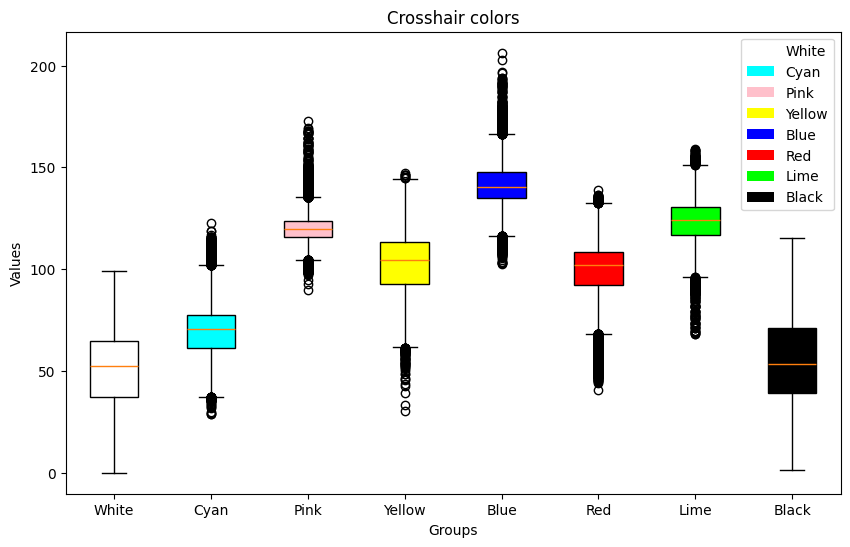

In [15]:
# Create a boxplot with custom colors
plt.figure(figsize=(10, 6))
bp = plt.boxplot([item[1] for item in color_data], labels=[item[0] for item in color_data], patch_artist=True)

# Set facecolor for each box based on the color_data tuples
for box, (color, _) in zip(bp['boxes'], color_data):
    box.set_facecolor(color)

# Add labels and title
plt.xlabel('Groups')
plt.ylabel('Values')
plt.title('Crosshair colors')

# Set legend for the boxplot colors
plt.legend([plt.Rectangle((0,0),1,1,fc=color) for color, _ in color_data], [item[0] for item in color_data], loc='upper right')

# Show the plot
plt.show()

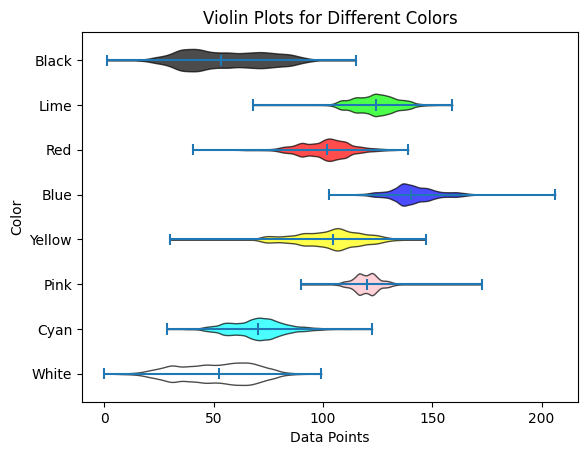

In [21]:
# Extract colors and data points from the list of tuples
colors, data_points = zip(*color_data)

# Create a figure and axis
fig, ax = plt.subplots()

# Create violin plots
violins = ax.violinplot(data_points, showmedians=True, vert=False)

# Customize the violin plots
for i, violin in enumerate(violins['bodies']):
    violin.set_facecolor(colors[i])
    violin.set_edgecolor('black')
    violin.set_alpha(0.7)

# Set labels and title
ax.set_yticks(np.arange(1, len(colors) + 1))
ax.set_yticklabels(colors)
ax.set_ylabel('Color')
ax.set_xlabel('Data Points')
ax.set_title('Violin Plots for Different Colors')

# Show the plot
plt.show()